# Решение задачи регрессии точек с использованием модели YoloV5 и обучением по нескольким примерам

В ноутбуке проверяется подход к решению задачи регрессии ключевых точек с помощью построения модели регрессии на feature map предобученной модели

* получаем feature map с помощью модели YoloV5
* тренируем модели линейной регрессии решать задачу k-points

Использованы картинки из датасета https://www.kaggle.com/datasets/crawford/cat-dataset

In [1]:
import pathlib
import sys

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from sklearn.linear_model import LinearRegression

sys.path.append("../yolov5")

In [2]:
from models.common import AutoShape, DetectMultiBackend

In [3]:
model = AutoShape(DetectMultiBackend("./yolov5x.pt"))

Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients, 205.7 GFLOPs
Adding AutoShape... 


## Feature map visualisation

In [4]:
x = model("cats/00000001_000.jpeg", profile=pathlib.Path("vis"))

In [5]:
%matplotlib inline

We can fisualise feature map in the intermediate layers

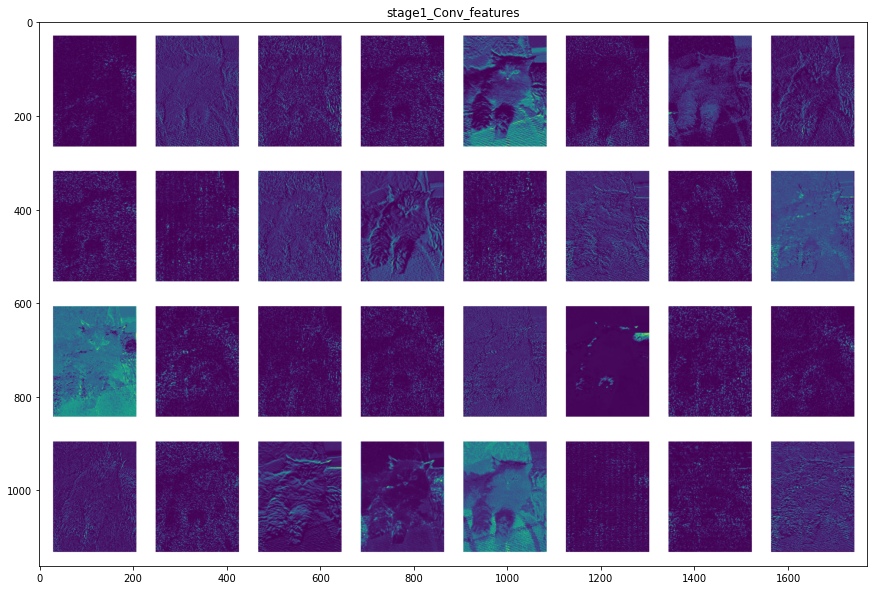

In [6]:
im = cv2.imread("vis/stage1_Conv_features.png", cv2.IMREAD_COLOR)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(25, 10))
plt.title("stage1_Conv_features")
plt.imshow(im)
plt.show()

Features are taken from 9th layer - last yolo backbone layer

see https://github.com/AsciiShell/yolov5/blob/master/models/yolov5x.yaml
```
# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]
```

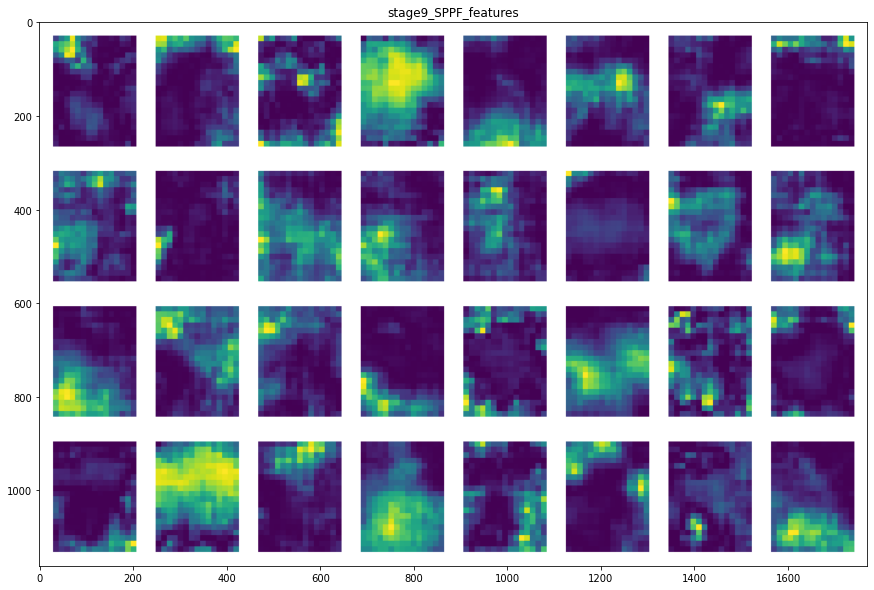

In [7]:
im = cv2.imread("vis/stage9_SPPF_features.png", cv2.IMREAD_COLOR)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(25, 10))
plt.title("stage9_SPPF_features")
plt.imshow(im)
plt.show()

## Model training

In [8]:
cat_names = [
    "cats/00000001_000.jpeg",
    "cats/00000001_005.jpeg",
    "cats/00000001_008.jpeg",
    "cats/00000001_011.jpeg",
    "cats/00000001_017.jpeg",
    "cats/00000001_012.jpeg",
    "cats/00000001_020.jpeg",
    "cats/00000001_024.jpeg",
]
cat_target = [
    [175, 160, 239, 162, 199, 199, 149, 121, 137, 78, 166, 93, 281, 101, 312, 96, 296, 133],
    [96, 96, 153, 127, 103, 146, 48, 20, 78, -37, 127, 5, 210, 52, 260, 63, 229, 121],
    [318, 222, 340, 224, 327, 238, 301, 199, 304, 182, 321, 196, 341, 197, 359, 183, 361, 203],
    [167, 173, 242, 185, 191, 247, 112, 105, 118, 0, 171, 74, 270, 90, 353, 35, 332, 147],
    [410, 464, 511, 344, 568, 494, 222, 473, 113, 370, 288, 359, 380, 250, 337, 75, 476, 200],
    [115, 122, 179, 121, 133, 169, 95, 70, 93, 17, 131, 46, 233, 39, 281, 9, 224, 69],
    [225, 125, 337, 139, 250, 200, 186, 93, 169, 12, 237, 60, 360, 79, 462, 51, 411, 124],
    [278, 121, 347, 121, 317, 179, 228, 79, 220, 12, 282, 61, 339, 60, 397, 16, 387, 76],
]
cat_target = np.array(cat_target)

In [9]:
x = model(cat_names)
t = torch.load("tensor.pt")
t.shape

torch.Size([8, 1280, 20, 20])

First 5 images are for train, other 3 for test

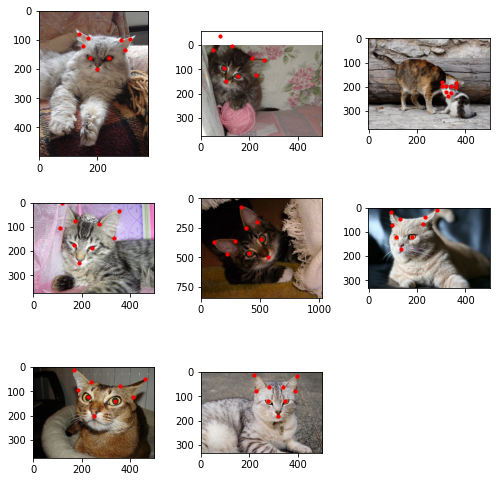

In [10]:
plt.figure(figsize=(7, 7), facecolor="w")
for i in range(len(cat_target)):
    plt.subplot(3, 3, i + 1)
    im = cv2.imread(cat_names[i], cv2.IMREAD_COLOR)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.imshow(im)
    plt.scatter(cat_target[i][::2], cat_target[i][1::2], s=10, c="red")
plt.tight_layout()
plt.show()

Для обучения будем брать центральный вектор из feature map + еще 8 ближайших векторов. Пробовали брать не центральный, а вектор из середины k-points - это лик, но особого улучшения не дал

Для каждого из 9 векторов target будет немного отличаться (k-points вычисляются осносительно центра выбранного вектора)

При инференсе реализован предикт для 9 векторов и усреднение предсказаний (результат не отличается, если брать только один центральный вектор и не усреднять результат)

In [11]:
features_train = []
features_test = []
inputs = []
target_train = []
for i in range(len(cat_target)):
    im = cv2.imread(cat_names[i], cv2.IMREAD_COLOR)
    height, width = im.shape[:2]
    image = torch.as_tensor(im.astype("float32").transpose(2, 0, 1))

    inp = [{"image": image, "height": height, "width": width}]
    inputs.append(inp[0])

    feature_map_size = 64
    x_target = cat_target[i][::2]
    y_target = cat_target[i][1::2]
    # середина feature map
    x = round(np.ceil(width / feature_map_size) / 2)
    y = round(np.ceil(height / feature_map_size) / 2)

    for x_ in range(x - 1, x + 2):
        for y_ in range(y - 1, y + 2):
            if i < 5:
                features_train.append(np.array(t[i, :, y_ - 1, x_ - 1]))
                x_center = feature_map_size * (x_ + 0.5)
                y_center = feature_map_size * (y_ + 0.5)
                target_train.append(
                    np.hstack([(x_target - x_center) / feature_map_size, (y_target - y_center) / feature_map_size])
                )

            features_test.append(np.array(t[i, :, y_ - 1, x_ - 1]))

Некоторые (близкие) вектора feature map действительно сильно коррелируют между собой

(1280, 3, 3)


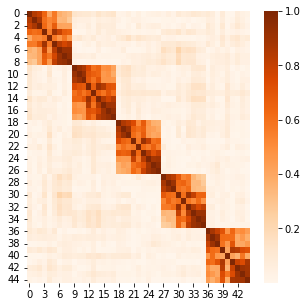

In [12]:
f = t[-1, :, y - 1 : y + 2, x - 1 : x + 2].detach().numpy()
print(f.shape)
f = f.reshape((256, -1))
f = np.abs(pd.DataFrame(f).corr())
plt.figure(figsize=(5, 5), facecolor="w")
sns.heatmap(f, cmap=plt.cm.Oranges);

In [13]:
np.array(features_train).shape, np.array(target_train).shape

((45, 1280), (45, 18))

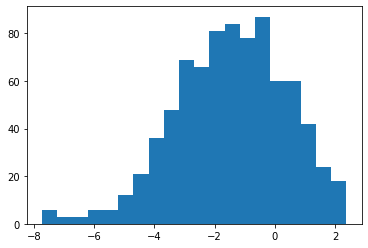

In [14]:
plt.hist(np.array(target_train).ravel(), bins=20);

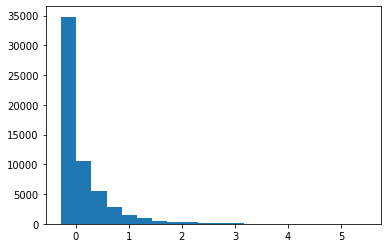

In [15]:
plt.hist(np.array(features_train).ravel(), bins=20);

In [16]:
regr = LinearRegression().fit(features_train, target_train)
regr.coef_.shape

(18, 1280)

In [17]:
def predict(X):
    prediction = []
    output = regr.predict(X).reshape((-1, 9, 18))

    for i in range(len(output)):
        h = inputs[i]["height"]
        w = inputs[i]["width"]
        pred = []
        for fm in output[i]:
            x_output = fm[:9] * feature_map_size
            y_output = fm[9:] * feature_map_size
            x_output += (np.round(np.ceil(w / feature_map_size) / 2) + 0.5) * feature_map_size
            y_output += (np.round(np.ceil(h / feature_map_size) / 2) + 0.5) * feature_map_size
            pred.append(np.hstack([x_output, y_output]))
        prediction.append(np.array(pred).mean(axis=0))
    return prediction

In [18]:
prediction = predict(features_test)

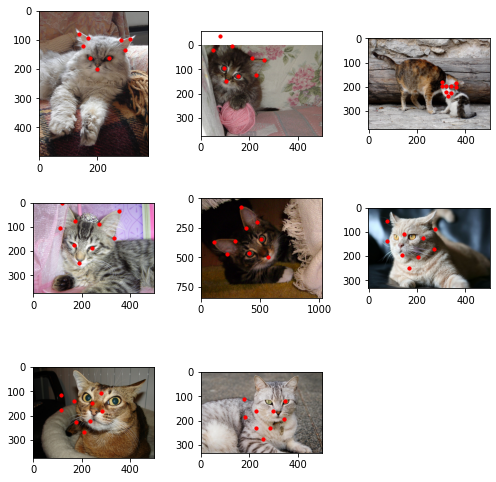

In [19]:
plt.figure(figsize=(7, 7), facecolor="w")
for i in range(len(cat_target)):
    plt.subplot(3, 3, i + 1)
    im = cv2.imread(cat_names[i], cv2.IMREAD_COLOR)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.imshow(im)
    plt.scatter(prediction[i][:9], prediction[i][9:], s=10, c="red")
plt.tight_layout()
plt.show()